The Notebook does a comparison of 3 Models which are Linear Regression, KNN & LSTM On Prediciting the price of a TATA Consumer Stock on NSE. Data was downloaded from NSEINDIA.com

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from fastai.tabular import  add_datepart


In [ ]:
# Read Data
df=pd.read_csv("NSE_TATA.csv")
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2022-04-22,818.0,821.60,803.10,811.60,815.60,1880668,15288.05349
1,2022-04-21,812.0,822.00,804.25,818.95,820.05,1344250,10958.17570
2,2022-04-20,800.0,813.45,792.10,810.10,810.45,1522453,12244.14776
3,2022-04-19,825.0,836.85,784.85,788.00,791.35,2460482,20063.01436
4,2022-04-18,816.2,824.90,809.00,822.50,822.30,1480954,12102.61050


In [ ]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,1561.000000,1561.000000,1561.00000,1561.000000,1561.000000,1.561000e+03,1561.000000
mean,348.303972,353.312460,343.06230,348.047341,348.034177,3.187189e+06,11480.285301
std,222.923844,225.242387,219.99598,222.566091,222.600846,3.349989e+06,14159.640225
min,103.000000,104.600000,100.00000,102.600000,102.650000,1.758370e+05,388.735415
25%,171.800000,173.850000,169.00000,171.000000,171.150000,1.518494e+06,3202.778609
50%,265.950000,271.250000,262.00000,266.200000,266.600000,2.329094e+06,7762.714725
75%,511.000000,517.850000,502.10000,508.600000,509.100000,3.662455e+06,15107.108290
max,885.000000,889.000000,877.60000,880.200000,882.100000,6.355260e+07,234317.687900


In [ ]:
# Convert Date to Timeseries
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
new_data['mon_fri'] = 0
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp


train = new_data[:1200]
valid = new_data[1200:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']


/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:64: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


285.8081464894287


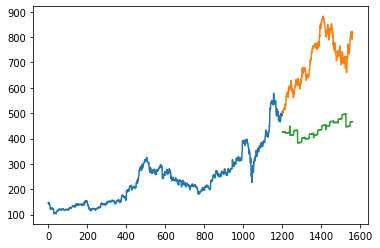

In [ ]:

#Implement linear regression
model = LinearRegression()
model.fit(x_train,y_train)

#Make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)

#Plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[1200:].index
train.index = new_data[:1200].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])



465.42700065611865


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


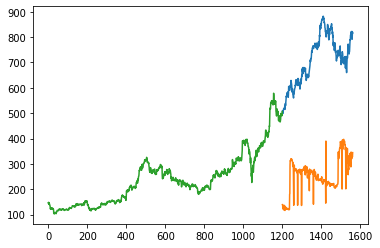

In [ ]:
#KNN Model
scaler = MinMaxScaler(feature_range=(0, 1))

#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)
#rms
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
print(rms)
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])


1140/1140 - 36s - loss: 0.0011 - 36s/epoch - 32ms/step
34.23942590418911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


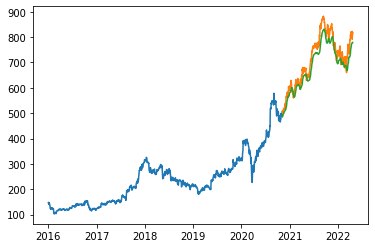

In [ ]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1200,:]
valid = dataset[1200:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

#rms
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
print(rms)

#plot
train = new_data[:1200]
valid = new_data[1200:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.show()